In [5]:
"""查看数据""" 
import pandas as pd
titanic = pd.read_csv('train.csv')
# titanic.head(3)
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# 用中值填补缺失值
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())

In [8]:
print(titanic['Sex'].unique())
# titanic.loc[0]表示第0行的样本
# titanic.loc[0, 'PassengerId']表示行为0，列为PassengerId的值
titanic.loc[titanic['Sex'] == 'male', 'Sex'] = 0
titanic.loc[titanic['Sex'] == 'female', 'Sex'] = 1

['male' 'female']


In [9]:
print(titanic['Embarked'].describe())
print(titanic['Embarked'].unique())
titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked'] == 'S', 'Embarked'] = 0
titanic.loc[titanic['Embarked'] == 'C', 'Embarked'] = 1
titanic.loc[titanic['Embarked'] == 'Q', 'Embarked'] = 2

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object
['S' 'C' 'Q' nan]


In [10]:
# 提炼新特征
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']
titanic['NameLength'] = titanic['Name'].apply(lambda x: len(x))
import re
import pandas as pd
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ''
titles = titanic['Name'].apply(get_title)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 8, "Mlle": 9,
                 "Mme": 10, "Don": 11, "Lady": 12, "Countess": 13, "Jonkheer": 14, "Sir": 15, "Capt": 16, "Ms": 17
                 }
for k, v in title_mapping.items():
    titles[titles == k] = v
print(pd.value_counts(titles))
titanic['Title'] = titles

1     517
2     182
3     125
4      40
5       7
6       6
8       2
7       2
9       2
16      1
10      1
11      1
12      1
13      1
14      1
15      1
17      1
Name: Name, dtype: int64


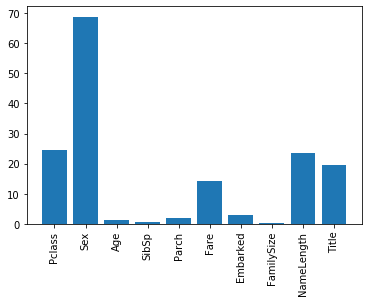

In [11]:
# 特征选择
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", 
"FamilySize", "NameLength", "Title"]
selector = SelectKBest(f_classif, k=5)# 方差分析，计算方差分析（ANOVA）的F值 (组间均方 / 组内均方)，选取前5个特征
selector.fit(titanic[predictors], titanic['Survived'])
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
#选择特征
predictors=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
#导入线性回归
alg=LinearRegression()
#将样本分成三份进行交叉验证
kf = KFold(n_splits=3, shuffle=False, random_state=1)
# kf=KFold(titanic.shape[0],n_splits=3,random_state=1)
predictions=[]
# for train_index,test_index in kf:
for train_index, test_index in kf.split(titanic):
    #用于训练的特征数据
    train_predictors=titanic[predictors].iloc[train_index,:]
    #特征数据的label（即是否获救）
    train_target=titanic['Survived'].iloc[train_index]
    #训练线性回归模型
    alg.fit(train_predictors,train_target)   
    test_predictions=alg.predict(titanic[predictors].iloc[test_index,:])
    predictions.append(test_predictions)
#线性回归得到的结果是在[0,1]
import numpy as np
# predictions[predictions > .5]=1
predictions = np.concatenate(predictions, axis=0)
predictions[predictions > .5] = 1
predictions[predictions <= .5] = 0
accuracy=sum(predictions==titanic['Survived'])/len(predictions)
print(accuracy)

0.7833894500561167


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
#初始化模型
alg=LogisticRegression(random_state=1)
scores=cross_val_score(alg,titanic[predictors],titanic['Survived'],cv=3)
print(scores)
print(scores.mean())

[0.79124579 0.79461279 0.8013468 ]
0.7957351290684623


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']
alg=RandomForestClassifier(random_state=1,n_estimators=20,min_samples_split=4,min_samples_leaf=2)
kf = KFold(n_splits=3,  shuffle=False, random_state=1)
acores=cross_val_score(alg,titanic[predictors],titanic['Survived'],cv=3)
print(scores.mean())

0.8013468013468014


D:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [93]:
from sklearn.ensemble import GradientBoostingClassifier 
import numpy as np
algorithms=[
    [RandomForestClassifier(random_state=1,n_estimators=20,min_samples_split=4,min_samples_leaf=2),
     ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'NameLength', 'Title']],
    [LogisticRegression(random_state=1),
     ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'NameLength', 'Title']]
]
kf = KFold(n_splits=11, shuffle=False)
predictions=[]
for train,test in kf.split(titanic):
    train_target=titanic['Survived'].iloc[train]
    full_test_prediction=[]
    for alg,predictors in algorithms:
        alg.fit(titanic[predictors].iloc[train,:],train_target)
        test_prediction=alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_prediction.append(test_prediction)
    #使用集成模型
    test_predictions=(full_test_prediction[0]*2+full_test_prediction[1]*1)/3
    test_predictions[test_predictions>.5]=1
    test_predictions[test_predictions<=.5]=0
    predictions.append(test_predictions)
predictions=np.concatenate(predictions,axis=0)
accuracy=sum(predictions==titanic['Survived'])/len(predictions)
print(accuracy)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_

0.8338945005611672


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [90]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# 通过集成两个分类器，达到最优的结果
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ['Pclass', 'Sex', 'Age', 'Fare','Embarked', 'FamilySize', 'Title']],
    [RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4), ['Pclass', 'Sex', 'Fare', 'FamilySize', 'Title', 'Age', 'Embarked']]

]

kf = KFold(n_splits=3, shuffle=False)

predictions = []

for train, test in kf.split(titanic):

    train_target = titanic['Survived'].iloc[train]
    full_test_predictions = []
    # 训练模型
    for alg, predictors in algorithms:
        alg.fit((titanic[predictors].iloc[train, :]), train_target)

        # 预测
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test, :].astype(float))[:, 1]
        full_test_predictions.append(test_predictions)
    # 使用简单的集成模型
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2

    # 对概率进行选择
    test_predictions[test_predictions <= 0.5] = 1
    test_predictions[test_predictions > 0.5] = 0
    predictions.append(test_predictions)

# Put all the predictions together into one array
predictions = np.concatenate(predictions, axis=0)

# 计算准确率
accuracy = sum(predictions == titanic['Survived']) / len(predictions)
print('-----------------1')
print(accuracy)

-----------------1
0.6161616161616161
